# Loading Fluview Data

In [9]:
# trying to use the epidata API
import sys
import subprocess
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'delphi-epidata'])

from delphi_epidata import Epidata
# we then use Epidata to grab the info we want

#ex: 
res = Epidata.covidcast('fb-survey', 'smoothed_cli', 'day', 'county', [20200401, Epidata.range(20200405, 20200414)], '06001')
print(res['result'], res['message'], len(res['epidata']))

# we want to use fluview

# nat is a region label

# fetch national FluView Clinical data for epiweeks 201940 and 202001-202010 (11 weeks total)
res = Epidata.fluview(['nat'], [201940, Epidata.range(202001, 202010)])
print(res['result'], res['message'], len(res['epidata']))

print(res['epidata'])

import json
formatted_output = json.dumps(res['epidata'], indent=2)
print(formatted_output)

# the average influenza infection lasts 5 - 7 days, but can last for longer than 2 weeks in serious cases
gamma = 1/7

# maybe we have a range of three values and see how our parameters and fit change?
# let's go with five different gamma values, varying by 2 days each
gammas = [1/3, 1/5, 1/7, 1/9, 1/11]

# now, let's grab the past 5 years of data from fluview so that we can estimate values

# the past 5 years, ending the first week of November 2025, will be the epiweeks of 
# Epidata.range(20201101, 20251101) <- a range of dates
# converting this to epiweeks:
# Epidata.range(202045, 202544)

past5yrs = Epidata.fluview(['nat'], [Epidata.range(202045, 202544)])
print(past5yrs['result'], past5yrs['message'], len(past5yrs['epidata']))

# practice
test = Epidata.fluview(['nat'], [Epidata.range(202045, 202047)])
print(test['result'], test['message'], len(test['epidata']))

ageGroup0 = []
ageGroup1 = []
ageGroup2 = []
ageGroup3 = []
ageGroup4 = []
for week in test['epidata']:
  temp1 = week['num_age_0']
  ageGroup0.append(temp1)

  # now, we need to extract the number of individuals infected for each age group from each result
ageGroup0 = [] # each of these is a separate x data array
ageGroup1 = []
ageGroup2 = []
ageGroup3 = []
ageGroup4 = []
for week in past5yrs['epidata']:
  temp = week['num_age_0']
  ageGroup0.append(temp)
  
  temp = week['num_age_1']
  ageGroup1.append(temp)
  
  temp = week['num_age_3']
  ageGroup2.append(temp)
  
  temp = week['num_age_4']
  ageGroup3.append(temp)
  
  temp = week['num_age_5']
  ageGroup4.append(temp)
  

print(ageGroup0)
print(len(ageGroup0))



# where t is the number of epiweeks since epiweek 45 of 2020


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


1 success 9
1 success 11
[{'release_date': '2021-10-08', 'region': 'nat', 'issue': 202139, 'epiweek': 201940, 'lag': 104, 'num_ili': 21916, 'num_patients': 1458307, 'num_providers': 2912, 'num_age_0': 6219, 'num_age_1': 7658, 'num_age_2': None, 'num_age_3': 4827, 'num_age_4': 1764, 'num_age_5': 1448, 'wili': 1.49002, 'ili': 1.50284}, {'release_date': '2021-10-08', 'region': 'nat', 'issue': 202139, 'epiweek': 202001, 'lag': 91, 'num_ili': 88731, 'num_patients': 1426691, 'num_providers': 2970, 'num_age_0': 21594, 'num_age_1': 23392, 'num_age_2': None, 'num_age_3': 27655, 'num_age_4': 9209, 'num_age_5': 6881, 'wili': 5.90066, 'ili': 6.21936}, {'release_date': '2021-10-08', 'region': 'nat', 'issue': 202139, 'epiweek': 202002, 'lag': 90, 'num_ili': 75614, 'num_patients': 1492251, 'num_providers': 3002, 'num_age_0': 15564, 'num_age_1': 22756, 'num_age_2': None, 'num_age_3': 23634, 'num_age_4': 8196, 'num_age_5': 5464, 'wili': 4.9402, 'ili': 5.06711}, {'release_date': '2021-10-08', 'region': 

# Varying Beta With Sinusoidal

0.6579653179945056 0.609570659296872


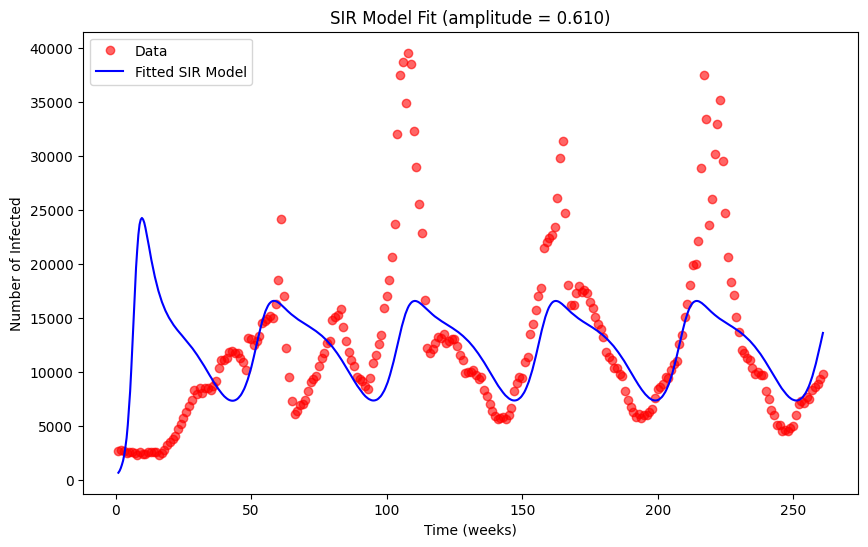

In [10]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

def SIRS_model(t, S0, I0, R0, beta, gamma, amplitude, period, N, zeta):
    stepsize = 0.05
    t_max = np.max(t)
    T = np.arange(0, t_max + stepsize, stepsize)
    
    S = np.zeros(len(T))
    I = np.zeros(len(T))
    R = np.zeros(len(T))
    
    S[0] = S0
    I[0] = I0
    R[0] = R0
    
    for idx in range(1, len(T)):
        t_current = T[idx]
        beta_t = beta * (1 + amplitude * np.sin(2 * np.pi * t_current / period))
        waning_immunity = zeta * R[idx-1]
        
        dS_dt = -beta_t * S[idx-1] * I[idx-1] / N + waning_immunity
        dI_dt = beta_t * S[idx-1] * I[idx-1] / N - gamma * I[idx-1]
        dR_dt = gamma * I[idx-1] - waning_immunity
        
        S[idx] = S[idx-1] + dS_dt * stepsize
        I[idx] = I[idx-1] + dI_dt * stepsize
        R[idx] = R[idx-1] + dR_dt * stepsize
        
    indices = (t / stepsize).astype(int)
    I_at_t = I[indices]
    return I_at_t



S0 = .999 * 40000
I0 = .01 * 40000
R0 = 0
N = S0 + I0 + R0
gamma = 1/7
period = 52
zeta = 0.1

time_data = np.arange(1, len(ageGroup0) + 1)
infection_data = ageGroup0


def model_wrapper(t, beta, amplitude):
    return SIRS_model(t, S0, I0, R0, beta, gamma, amplitude, period, N, zeta)

params, pcov = scipy.optimize.curve_fit(model_wrapper, time_data, infection_data, bounds=([0, 0], [5, 1]))
beta, amplitude = params[0], params[1]
print(beta, amplitude)

t_smooth = np.linspace(1, len(infection_data), 600)
fitted_curve = SIRS_model(t_smooth, S0, I0, R0, beta, gamma, amplitude, period, N, zeta)

plt.figure(figsize=(10, 6))
plt.plot(time_data, infection_data, 'o', color="red", label="Data", alpha=0.6)
plt.plot(t_smooth, fitted_curve, '-', color="blue", label="Fitted SIR Model")
plt.legend()
plt.xlabel("Time (weeks)")
plt.ylabel("Number of Infected")
plt.title(f"SIR Model Fit (amplitude = {amplitude:.3f})")
plt.show()

# Varying Beta With Temperature 

Optimal Beta Baseline: 0.6858235259971976
Optimal Temperature Sensitivity: 0.030214661179645302


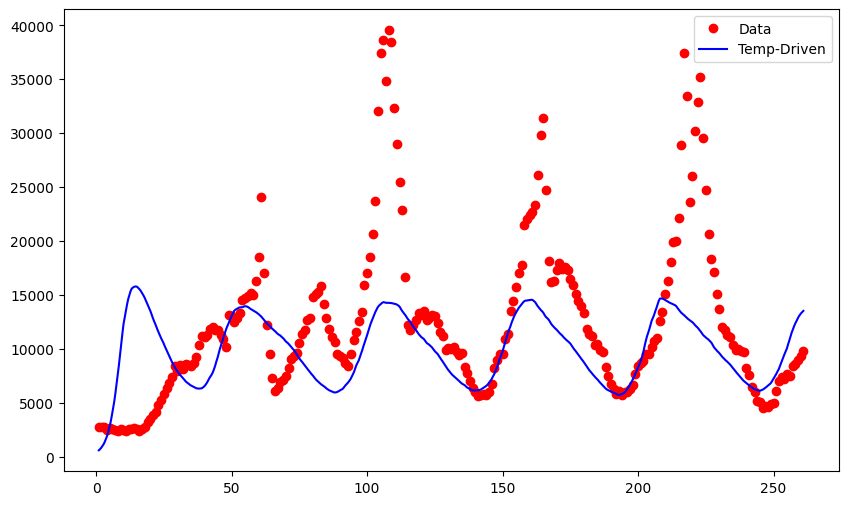

In [11]:
from meteostat import Point, Daily
from datetime import datetime

locations = [
    Point(47.4502, -122.3088, 122),   # Seattle-Tacoma
    Point(37.6213, -122.3790, 5),     # San Francisco
    Point(33.9425, -118.4081, 38),    # Los Angeles
    Point(41.8781, -87.6298, 181),    # Chicago
    Point(40.7128, -74.0060, 10),     # New York City
    Point(33.7490, -84.3880, 313)     # Atlanta
]
start = datetime(2019, 1, 1)
end = datetime(2024, 12, 31)
all_temps = []

for i, location in enumerate(locations):
    try:
        data = Daily(location, start, end)
        data = data.fetch()
        if not data.empty and 'tavg' in data.columns:
            temps_array = data['tavg'].values
            if np.sum(~np.isnan(temps_array)) > len(temps_array) * 0.5:
                all_temps.append(temps_array)
    except Exception as e:
        pass

avg_temps = np.nanmean(all_temps, axis=0)
weekly_temps = []   
for i in range(0, len(avg_temps), 7):
    week_temp = np.nanmean(avg_temps[i:i+7])
    if not np.isnan(week_temp):
        weekly_temps.append(week_temp)
temps = np.array(weekly_temps)

def SIRS_model_temp(t, S0, I0, R0, beta_baseline, gamma, sensitivity, N, zeta, temp_data):
    stepsize = 0.05
    t_max = np.max(t)
    T = np.arange(0, t_max + stepsize, stepsize)
    
    S = np.zeros(len(T))
    I = np.zeros(len(T))
    R = np.zeros(len(T))
    
    S[0] = S0
    I[0] = I0
    R[0] = R0

    for idx in range(1, len(T)):
        t_current = T[idx]
        temp_idx = int(t_current) % len(temp_data)

        beta_t = beta_baseline * (1 - sensitivity * temp_data[int(temp_idx)])
        
        waning_immunity = zeta * R[idx-1]
        dS_dt = -beta_t * S[idx-1] * I[idx-1] / N + waning_immunity
        dI_dt = beta_t * S[idx-1] * I[idx-1] / N - gamma * I[idx-1]
        dR_dt = gamma * I[idx-1] - waning_immunity
        S[idx] = S[idx-1] + dS_dt * stepsize
        I[idx] = I[idx-1] + dI_dt * stepsize
        R[idx] = R[idx-1] + dR_dt * stepsize
    
    indices = (t / stepsize).astype(int)
    return I[indices]

def model_wrapper(t, beta_baseline, sensitivity):
    return SIRS_model_temp(t, S0, I0, R0, beta_baseline, gamma, sensitivity, N, zeta, temps)


p0 = [1.0, 0.2]
params, pcov = scipy.optimize.curve_fit(model_wrapper, time_data, infection_data, p0=p0, bounds=([0, 0], [1, 1]))

print(f"Optimal Beta Baseline: {params[0]}")
print(f"Optimal Temperature Sensitivity: {params[1]}")

t_smooth = np.linspace(1, len(infection_data), 600)
fitted_curve = SIRS_model_temp(t_smooth, S0, I0, R0, params[0], gamma, params[1], N, zeta, temps)

plt.figure(figsize=(10, 6))
plt.plot(time_data, infection_data, 'o', color="red", label="Data")
plt.plot(t_smooth, fitted_curve, '-', color="blue", label="Temp-Driven")
plt.legend()
plt.show()

# Analysis

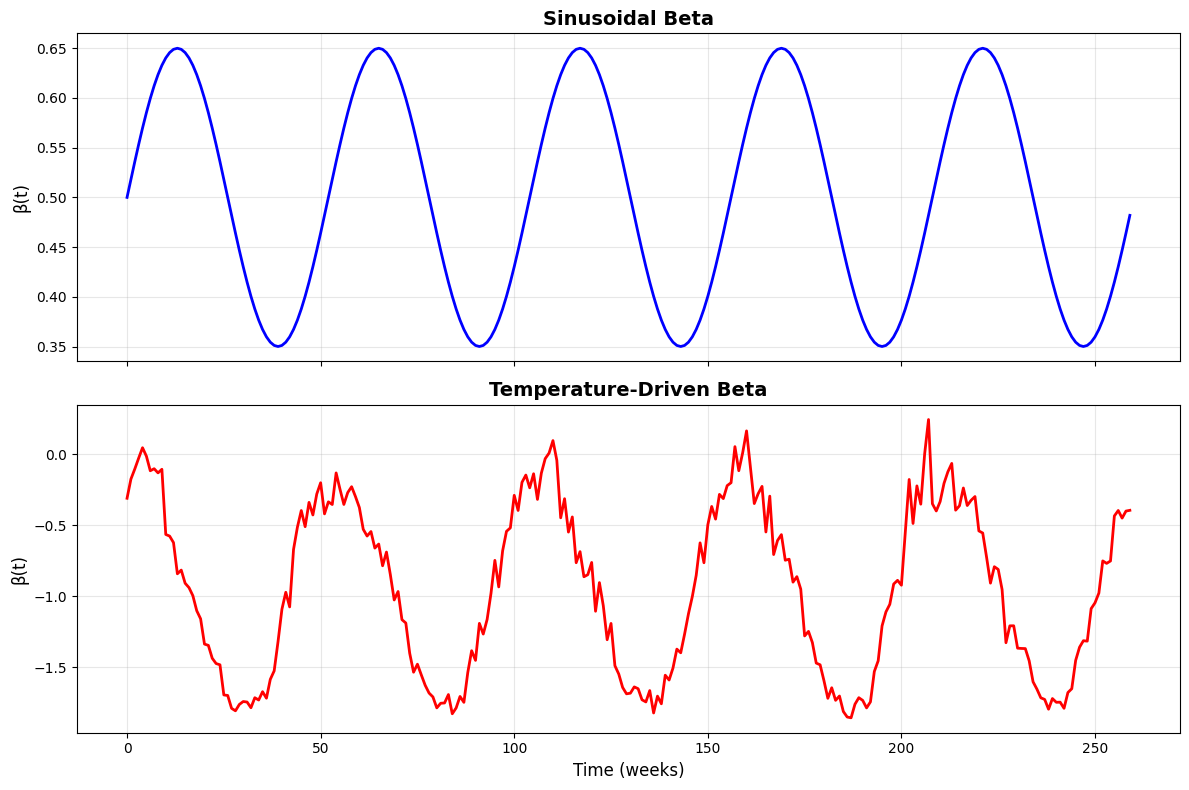

In [12]:
beta_baseline = 0.5
amplitude = 0.3
period = 52
sensitivity = 0.2
weeks = 260
t = np.arange(0, weeks)
beta_sin = beta_baseline * (1 + amplitude * np.sin(2 * np.pi * t / period))
temp_indices = (t % len(temps)).astype(int)
beta_temp = beta_baseline * (1 - sensitivity * temps[temp_indices])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax1.plot(t, beta_sin, color='blue', linewidth=2)
ax1.set_ylabel('β(t)', fontsize=12)
ax1.set_title('Sinusoidal Beta', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax2.plot(t, beta_temp, color='red', linewidth=2)
ax2.set_xlabel('Time (weeks)', fontsize=12)
ax2.set_ylabel('β(t)', fontsize=12)
ax2.set_title('Temperature-Driven Beta', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

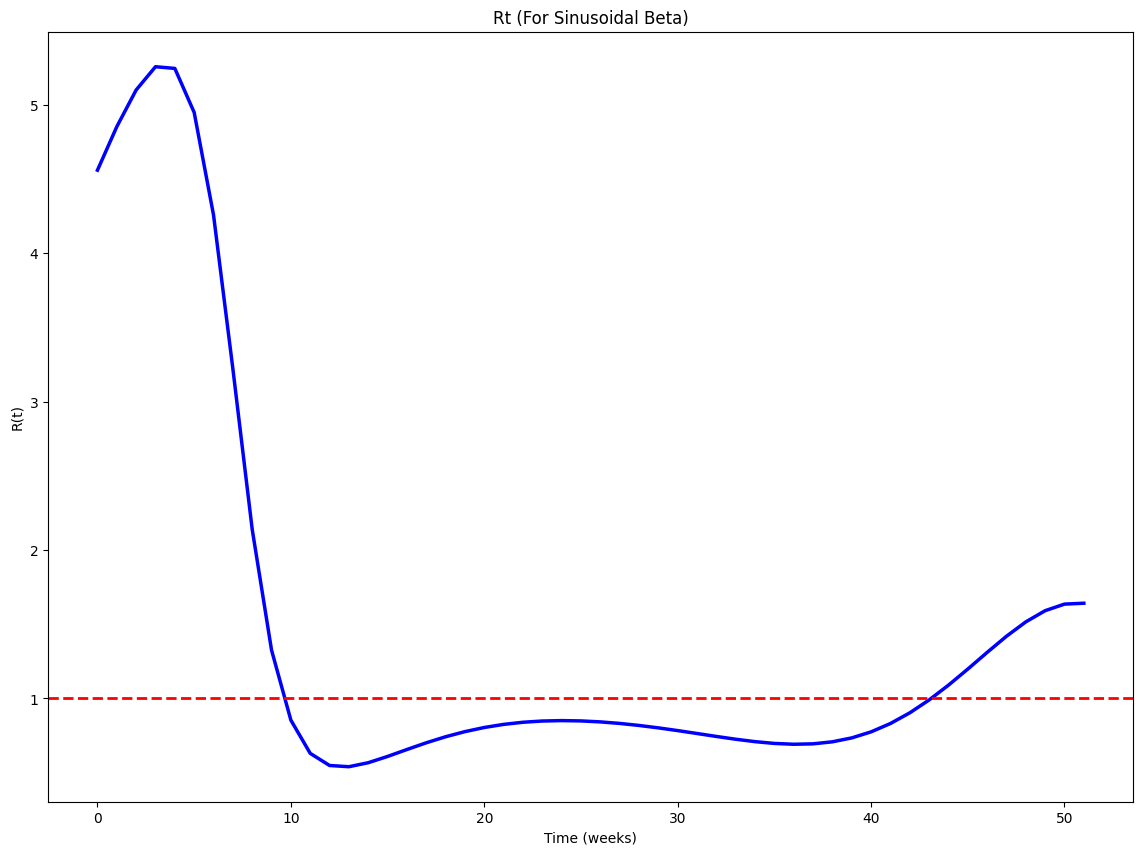

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

S0 = 0.999 * 40000
I0 = 0.01 * 40000
R0 = 0
N = S0 + I0 + R0
gamma = 1/7

beta_baseline_sin, amplitude = 0.6579653179945056, 0.609570659296872
period = 52


def sin_Rt(t, S, beta_baseline, amplitude, period, gamma, N):
    beta_t = beta_baseline * (1 + amplitude * np.sin(2 * np.pi * t / period))
    Rt = beta_t * S / (gamma * N)
    return Rt

def simulate_SIRS_sin(weeks, S0, I0, R0, beta_baseline, gamma, amplitude, period, N, zeta=0.1):
    stepsize = 0.1
    steps = int(weeks / stepsize)
    
    S = np.zeros(steps)
    I = np.zeros(steps)
    R = np.zeros(steps)
    
    S[0] = S0
    I[0] = I0
    R[0] = R0
    
    for idx in range(1, steps):
        t_current = idx * stepsize
        beta_t = beta_baseline * (1 + amplitude * np.sin(2 * np.pi * t_current / period))
        
        waning = zeta * R[idx-1]
        dS_dt = -beta_t * S[idx-1] * I[idx-1] / N + waning
        dI_dt = beta_t * S[idx-1] * I[idx-1] / N - gamma * I[idx-1]
        dR_dt = gamma * I[idx-1] - waning
        
        S[idx] = S[idx-1] + dS_dt * stepsize
        I[idx] = I[idx-1] + dI_dt * stepsize
        R[idx] = R[idx-1] + dR_dt * stepsize
    
    return S, I, R


S_sin, I_sin, R_sin = simulate_SIRS_sin(52, S0, I0, R0, beta_baseline_sin, 
                                                gamma, amplitude, period, N)

t_plot = np.arange(0, weeks, 1)
stepsize = 0.1
indices = (t_plot / stepsize).astype(int)
Rt_sin = sin_Rt(t_plot, S_sin[indices], beta_baseline_sin, amplitude, period, gamma, N)

fig, ax1 = plt.subplots(1, 1, figsize=(14, 10), sharex=True)
ax1.plot(t_plot, Rt_sin, color='blue', linewidth=2.5, label='R(t)')
ax1.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Threshold (R=1)')
ax1.set_ylabel('R(t)')
ax1.set_xlabel('Time (weeks)')
ax1.set_title('Rt (For Sinusoidal Beta)')
plt.show()
